In [7]:
%run ../modules.ipynb
"""Importing the dataset from matminer only once"""
# from matminer.datasets import load_dataset
# df = load_dataset("mp_all_20181018")
# compression_opts = dict(method='zip',archive_name='MP_complete.csv')  
# df.to_csv('MP_complete.zip', index=False,compression=compression_opts)  

'Importing the dataset from matminer only once'

In [2]:
"""The file has been created in zip format, reading it"""
zf = zipfile.ZipFile('./MP_complete.zip') 
df_csv = pd.read_csv(zf.open('MP_complete.csv'))

In [3]:
frames_init_tot=ase.io.read('MP_complete_init.xyz', index=':')
frames_relax_tot=ase.io.read('MP_complete_relax.xyz', index=':')

natoms_list_tot=[]
for i in range(len(df_csv)):
    natoms_list_tot.append(natoms(df_csv['structure'][i]))

len(frames_init_tot), len(frames_relax_tot), len(natoms_list_tot)

(83989, 83989, 83989)

In [4]:
select=80000
frames_init, frames_relax, natoms_list = zip(*random.sample(list(zip(frames_init_tot, frames_relax_tot, natoms_list_tot)), select))
len(frames_init), len(frames_relax), len(natoms_list)


(80000, 80000, 80000)

In [5]:
pg_list_order=['1', '1_','2','m','2/m', 
               'mm2','222',  'mmm',
               '4', '4_',  '4_2m','4mm', '422', '4/m','4/mmm',
               '3', '3m', '3_','32', '3_m','6', '6_',
                '6_m2',  '6/m','622','6mm',  '6/mmm', 
                '23',   '4_3m', '432', 'm_3', 'm3_m']

# prec=[0.01, 0.1]
# angl=[5, 10]

prec=[0.01]
angl=[5]


80000 80000 80000


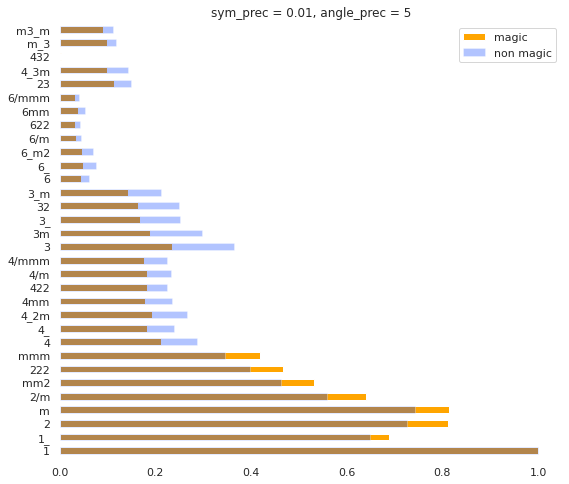

number of failures is  0


In [8]:
for j in prec:
    for k in angl:
        error=0
        point_group_list=[]
        magic=np.zeros(len(frames_init))
        n_atoms=[]
        for frame,i in zip(frames_init, range(len(frames_init))):
            natom=len(frame)
            if natom %4==0:
                magic[i]=1
            n_atoms.append(natom)
            py=get_pymatgen(frame)
            try:
                new=SA(py, symprec=j, angle_tolerance=k).find_primitive()
                sg=SA(py, symprec=j, angle_tolerance=k).get_space_group_number()
            except:
                error+=1
                pass
            
            sp_group=point_group(sg)
            point_group_list.append(pg)
            
        print(len(point_group_list), len(magic), len(n_atoms))
            
        dict={'point_group':point_group_list,'natom': n_atoms, 'magic':magic} 
        df= pd.DataFrame(dict)

        m=df.loc[df['magic'] == 1]
        m=m.drop(['natom', 'magic'], axis=1)
        nm=df.loc[df['magic'] == 0]
        nm=nm.drop(['natom', 'magic'], axis=1)

        inh_symm_m=inh_symm(m['point_group'])
        inh_symm_whole=inh_symm(df['point_group'])
        inh_symm_nm=inh_symm(nm['point_group'])

        inh_symm_m=inh_symm_m.reindex(pg_list_order)
        inh_symm_nm=inh_symm_nm.reindex(pg_list_order)
        inh_symm_whole=inh_symm_whole.reindex(pg_list_order)

        inh_symm_m=inh_symm_m/inh_symm_m['1']
        inh_symm_nm=inh_symm_nm/inh_symm_nm['1']

        sns.set(style="white", palette="bright", color_codes=True)
        f, ax = plt.subplots(figsize=(9, 8))
        sns.despine(left=True, bottom=True)
        inh_symm_m.plot(kind='barh', title='Inherited symmetry', color='orange', label='magic')
        inh_symm_nm.plot(kind='barh', color='b', alpha=0.3, label='non magic')
        plt.legend()
        plt.title("sym_prec = "+str(j)+", angle_prec = "+str(k))
        plt.show()
        plt.close()
        
        print("number of failures is ", error)

In [ ]:
dict={'point_group':point_group_list,'natom': n_atoms, 'magic':magic} 
df= pd.DataFrame(dict)
print((df['point_group'].unique()))
m=df.loc[df['magic'] == 1]
m=m.drop(['natom', 'magic'], axis=1)
nm=df.loc[df['magic'] == 0]
print((nm['point_group'].unique()))
nm=nm.drop(['natom', 'magic'], axis=1)
plt.style.use('seaborn')
f, ax = plt.subplots(figsize=(9, 8))
sns.despine(left=True, bottom=True)
g=sns.histplot(data=df, x='point_group', hue='magic',stat='density', multiple='dodge', shrink=.8)
plt.xticks(c='grey', rotation=90)
plt.yticks(c='grey')
plt.ylabel('Count', c='grey')
plt.xlabel('Point group', c='grey')
# prec=np.linspace(0.001, 0.1, 20)
# angl=np.linspace(0, 5, 20)
# prec,angl

In [ ]:
"""Using function in modules.ipynb to produce inherited symmetry - problem with 432 group """

inh_symm_m=inh_symm(m['point_group'])
inh_symm_whole=inh_symm(df['point_group'])
inh_symm_nm=inh_symm(nm['point_group'])

inh_symm_m=inh_symm_m.reindex(pg_list_order)
inh_symm_nm=inh_symm_nm.reindex(pg_list_order)
inh_symm_whole=inh_symm_whole.reindex(pg_list_order)

# print(inh_symm_whole, inh_symm_m, inh_symm_nm)

inh_symm_m=inh_symm_m/inh_symm_m['1']
inh_symm_nm=inh_symm_nm/inh_symm_nm['1']

sns.set(style="white", palette="bright", color_codes=True)
f, ax = plt.subplots(figsize=(9, 8))
sns.despine(left=True, bottom=True)
inh_symm_m.plot(kind='barh', title='Inherited symmetry', color='orange', label='magic')
inh_symm_nm.plot(kind='barh', color='b', alpha=0.3, label='non magic')
plt.legend()

In [ ]:
#structures that change from magic to non magic when ajusting tolerance
data=[]
for j in prec:
    for k in angl:
        magic_count=0
        change_count=0
        error=0
        for frame in frames_init:
            py=get_pymatgen(frame)
            if len(py)%4==0:
                magic_count+=1  
            try:
                new=SA(py, symprec=j, angle_tolerance=k).find_primitive()
            except:
                error+=1
                pass
                if (len(new)!=len(py)) and len(new)%4!=0:
                    change_count+=1
        change_perc=change_count*100/magic_count
        error_perc=error*100/magic_count
        data.append([j,k,change_perc, error_perc])
        print("PRIMITIVE: ", str(change_perc), "+_",str(error_perc), 
              "% of structures change from magic to non magic with symprec = ", str(j), 
              "and angle_tol = ", str(k))
        
        #structures that change from magic to non magic when ajusting tolerance
data_conv=[]
for j in prec:
    for k in angl:
        magic_count=0
        change_count=0
        error=0
        for frame in frames_init:
            py=get_pymatgen(frame)
            if len(py)%4==0:
                magic_count+=1  
            try:
                new=SA(py, symprec=j, angle_tolerance=k).get_conventional_standard_structure(international_monoclinic=True)
            except:
                error+=1
                pass
                if (len(new)!=len(py)) and len(new)%4!=0:
                    change_count+=1
        change_perc=change_count*100/magic_count
        error_perc=error*100/magic_count
        data_conv.append([j,k,change_perc, error_perc])
        print("PRIMITIVE: ", str(change_perc), "+_",str(error_perc), 
              "% of structures change from magic to non magic with symprec = ", str(j), 
              "and angle_tol = ", str(k))
        
data_relax=[]
for j in prec:
    for k in angl:
        magic_count=0
        change_count=0
        error=0
        for frame in frames_relax:
            py=get_pymatgen(frame)
            if len(py)%4==0:
                magic_count+=1  
            try:
                new=SA(py, symprec=j, angle_tolerance=k).find_primitive()
            except:
                error+=1
                pass
                if (len(new)!=len(py)) and len(new)%4!=0:
                    change_count+=1
        change_perc=change_count*100/magic_count
        error_perc=error*100/magic_count
        data_relax.append([j,k,change_perc, error_perc])
        print("PRIMITIVE: ", str(change_perc), "+_",str(error_perc), 
              "% of structures change from magic to non magic with symprec = ", str(j), 
              "and angle_tol = ", str(k))
data_relax_conv=[]
for j in prec:
    for k in angl:
        magic_count=0
        change_count=0
        error=0
        for frame in frames_relax:
            py=get_pymatgen(frame)
            if len(py)%4==0:
                magic_count+=1  
            try:
                new=SA(py, symprec=j, angle_tolerance=k).get_conventional_standard_structure(international_monoclinic=True)
            except:
                error+=1
                pass
                if (len(new)!=len(py)) and len(new)%4!=0:
                    change_count+=1
        change_perc=change_count*100/magic_count
        error_perc=error*100/magic_count
        data_relax_conv.append([j,k,change_perc, error_perc])
        print("PRIMITIVE: ", str(change_perc), "+_",str(error_perc), 
              "% of structures change from magic to non magic with symprec = ", str(j), 
              "and angle_tol = ", str(k))


In [ ]:
data=np.array(data)
data_conv=np.array(data_conv)
data_relax=np.array(data_relax)
data_relax_conv=np.array(data_relax_conv)

In [ ]:
plt.style.use('fivethirtyeight')

ax = plt.figure(figsize=(12,10)).add_subplot(projection='3d')

ax.scatter(data[:,0], data[:,1], data[:,2],  
        s=200, linewidth=1, label='initial primitive', color='b')

ax.scatter(data_conv[:,0], data_conv[:,1], data_conv[:,2],  
        s=150, linewidth=1, label='initial conventional', color='r')

ax.scatter(data_relax[:,0], data_relax[:,1], data_relax[:,2],  
        marker='s',s=100,  linewidth=1, label='relaxed primitive', color='orange')

ax.scatter(data_relax_conv[:,0], data_relax_conv[:,1], data_relax_conv[:,2], 
        s=50, label='relaxed conventional', color='g')

ax.set_xlabel("Sym prec", size=20)
ax.set_ylabel("Angle prec", size=20)
ax.set_zlabel("% Lost Magicness", size=20)
ax.set_zlim(0,0.04)
ax.legend(fontsize=20)
ax.set_title("Materials Project: Tuning symmetries' tolerance", color='grey', size=28)


In [ ]:
errors=[data[:,3], data_conv[:,3], data_relax[:,3], data_relax_conv[:,3]]
errors